# Data Stack Preparation (data-prep)

This tutorial will walk you through the workflow of the [VegMapper](https://github.com/NaiaraSPinto/VegMapper) repo. At the end of this tutorial, you will create multi-band geotiffs that can be used for the identification and classification of specific agroforestry systems, such as palm-oil plantations.

NOTE: The routines in this notebook will work best if the notebook is launced from an AWS EC2 instance with the conda evironment activated. A tutorial for setting up a jupyter server on an EC2 instance can be found here **(TODO: inlcude link)**. Instructions for setting up the conda environment can be found in [section 2](#2.-Set-up-vegmapper-conda-environment) of this notebook.

## 1. Get credentials ##
This repo makes use of several third-party services which will require credentials. These can be obtained using the following links. Please note that approval of an account may take several days for certain services.

1) [NASA Earthdata](https://urs.earthdata.nasa.gov/users/new)

2) [JAXA](https://www.eorc.jaxa.jp/ALOS/en/palsar_fnf/registration.htm)

3) [AWS S3/EC2](https://portal.aws.amazon.com/billing/signup#/start) or [Google Cloud Storage/GCS](https://cloud.google.com/storage/), if planning to use cloud storage (recommended).

4) [Google Earth Engine](https://earthengine.google.com/)

One-time authentication for Google Earth Engine:

In [ ]:
import ee
ee.Authenticate()

## 2. Set up vegmapper conda environment ##

This notebook requires Anaconda to be installed to download Python packages and set up the **vegmapper** environment. Anaconda can be downloaded [here](https://www.anaconda.com/products/individual).

Once Anaconda has been installed, clone the [VegMapper](https://github.com/NaiaraSPinto/VegMapper) repo by running the following command in your terminal:
```
% git clone https://github.com/NaiaraSPinto/VegMapper.git
```
Next, create the **vegmapper** environment and install required packages by running these commands in your terminal:

```
% cd VegMapper
% conda env create -f vegmapper.yml
% conda activate vegmapper
```

## 3. Set up project directory ##

This repo will make use of one consistent project directory, referred from here as `proj_dir`. The name of `proj_dir` is up to you, but all subfolders and completed tiles will be generated automatically. The completed stacks as well as any intermediate products will be stored in `proj_dir`. At the moment, AWS S3, GCS, and local storage systems are supported. Some extra setup may be required, depending on your storage system of choice:

* To set up AWS Command Line Interface (CLI) configurations and credentials (required if your `proj_dir` is S3):

    ```
    (vegmapper) % aws configure
    ```

    where you will be asked to enter your **aws_access_key_id** and **aws_secret_access_key**.
    
    If using S3, then `proj_dir` should be `s3://your_bucket/some_prefix` when used as an argument to scripts.


* To set up Google Cloud gsutil tool (required if your `proj_dir` is GCS):

    ```
    (vegmapper) % gsutil config
    ```

    Then you will be prompted to sign in using your Google credentials.
    
    If using GCS, then `proj_dir` should be `gs://your_bucket/some_prefix` when used as an argument to scripts.
    
    
* If using local storage, create a new folder at the desired location in your filesystem. If using local storage, then `proj_dir` should be `your_local_path` when passed as an argument to scripts. Note that `your_local_path` must point to a directory that exists--it will not be automatically generated for you. 

    **Warning:** using local storage is not advised as the stacks generated will be large files, and some steps will be faster if run in the cloud. 

In [34]:
# only use s3
# set up aoi_shp, csv/geojson in bucket beforehand

Set `proj_dir` to your project directory:

In [19]:
proj_dir = 's3://servir-public/dummy/'
proj_dir

's3://servir-public/dummy/'

In [23]:
!aws s3 ls {proj_dir}

2022-02-09 19:23:39          0 


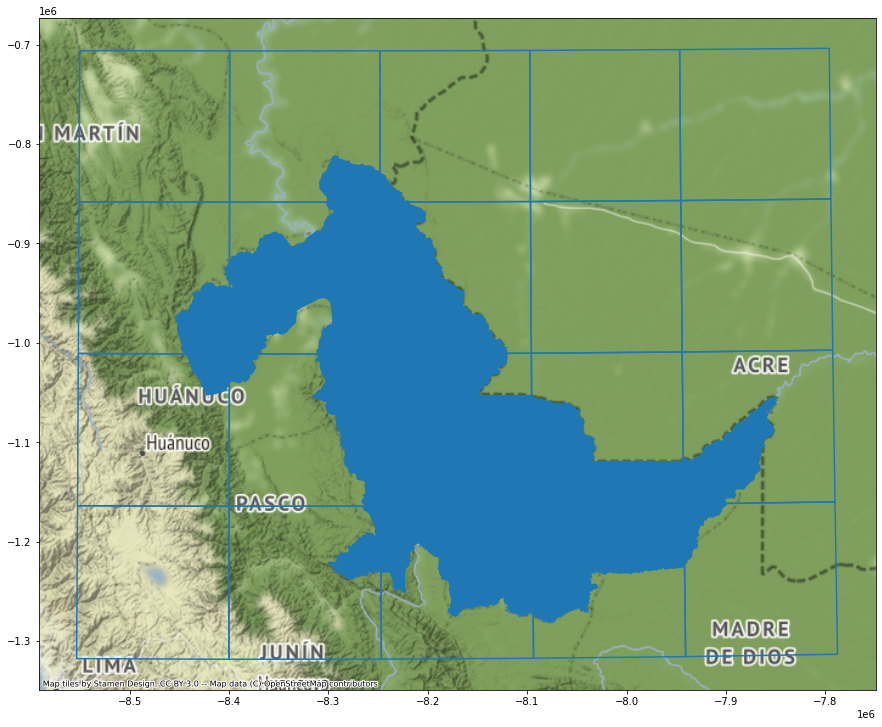

In [5]:
fill = True
outline = False
plot(["AOI/ucayali/ucayali_boundary.geojson", "AOI/ucayali/ucayali_tiles.geojson"], [fill, outline], (15, 15))

## 4. Prepare UTM tiles for Area of Interest (AOI): `prep_tiles.py` ##

To create the stacks, a universal tiling system is required to ensure all data sources are aligned to the same grid. In the following section, we will generate a geoJSON file that contains the tiles to be used by all of the data processing scripts. This is accomplished via the `prep_tiles.py` script.

#### Usage ####

```
(vegmapper) % python prep_tiles.py [-h] aoi_name aoi_shp tile_size
```

|Arguments||Description||Required||Default|
|----||----||----||----|
|`aoi_name`||Used to name the output geoJSON. The generated tiles can be found at `aoi_name`_tiles.geojson.||Yes||None|
|`aoi_shp`||shp/geoJSON file that contains the boundaries of our area of interest. geoJSON files for many subnational administrative boundaries can be found [here](https://data.humdata.org/dataset?ext_subnational=1&res_format=GeoJSON&vocab_Topics=administrative%20divisions&q=&sort=if(gt(last_modified%2Creview_date)%2Clast_modified%2Creview_date)%20desc&ext_page_size=25).||Yes||None|
|`tile_size`||The desired tile size, in meters.||Yes||None|

In [30]:
# Set arguments for prep_tiles.py
aoi_name = "ucayali"
# aoi_shp = "AOI/ucayali/ucayali_boundary.geojson"
aoi_shp = "s3://servir-stacks/ucayali/ucayali_boundary.geojson"
tile_size = 150000

aoi_name, aoi_shp, tile_size

('ucayali', 's3://servir-stacks/ucayali/ucayali_boundary.geojson', 150000)

In [33]:
# should be able to have all files in s3 bucket

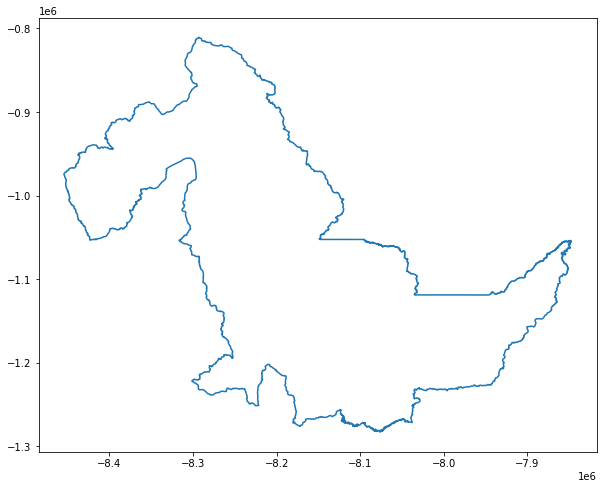

In [31]:
# Plot our AOI to make sure it looks right
fill_boundary = False
plot([aoi_shp], [fill_boundary], (10, 10))

Generate the UTM tiles by running the cell below:

In [ ]:
python Utils/prep_tiles.py {aoi_name} {aoi_shp} {tile_size}

In [24]:
# Set the value of aoi to the file containing the output tiles, to be used later in the notebook
aoi = f"{aoi_name}_tiles.geojson"
aoi

'ucayali_tiles.geojson'

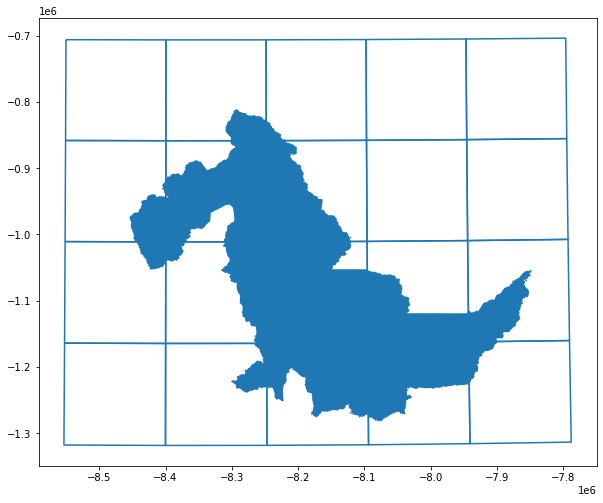

In [25]:
# Plot our tiles against our original AOI to make sure it looks right
fill_boundary = True
fill_tiles = False
plot([aoi_shp, aoi], [fill_boundary, fill_tiles], (10, 10))

Note that some tiles might not intersect our AOI. These will be masked out and will not be used to generate the final stacks.

## 5. Prepare Sentinel-1 Tiles ##

The first piece of the data stack is Sentinel-1 tiles. In the following section, we search for granules within our AOI, process them using the ASF HyP3 API, and calculate statistics for the granules.

### Search for Sentinel-1 granules on [ASF Vertex](https://search.asf.alaska.edu/#/) ###

First, we must download a CSV or geoJSON file containing a list of granules we wish to submit for processing using the ASF Vertex Data Search tool.

1. Sign in using your Earthdata credentials, which were obtained in [section 1](#1.-Get-credentials). If you haven't used ASF Vertex before, you will need to agree their terms in order to use their HyP3 processing.

2. Use the following "Additional Filters" when searching for granules within your AOI:

    * File Type: L1 Detected High-Res Dual-Pol (GRD-HD)
    * Beam Mode: IW
    * Polarization: VV+VH

    ![vertex_search_filters](img/vertex_search_filters.png)

3. Add the selected granules into the download queue:

    ![vertex_add_queue](img/vertex_add_queue.png)

4. Download metadata files. Download at least one csv or geojson file, which will be used for submitting HyP3 jobs.

    ![vertex_download_metadata](img/vertex_download_metadata.png)

5. Clear the selected granules in the downloads. Do not download these GRD-HD products as we will submit HyP3 jobs to apply radiometric terrain correction (RTC) to them.

Set `csv/geojson` to the CSV/geoJSON file we just downloaded:

In [37]:
csv_geojson = "Sentinel/granules/ucayali/ucayali_sentinel_granules_2017.geojson"
csv_geojson

'Sentinel/granules/ucayali/ucayali_sentinel_granules_2017.geojson'

### Submit HyP3 RTC jobs: `s1_submit_hyp3_jobs.py` ###

For the initial processing of the Sentinel-1 granules, we make use of ASF's HyP3 API. Information about the specifics of this processing can be found in the [HyP3 documentation](https://hyp3-docs.asf.alaska.edu/). `s1_submit_hyp3_jobs.py` will submit the granules chosen in the previous step to the HyP3 API for processing. The processed granules will be saved in the following directory structure, as .zip files:
```
        proj_dir
           └──sentinel_1
               └──<year>
                   └──<path_frame>
```

#### Usage ####

```
(vegmapper) % python s1_submit_hyp3_jobs.py [-h] proj_dir csv/geojson
```

|Arguments||Description||Required||Default|
|----||----||----||----|
|`proj_dir`||Your project directory (see [section 3](#3.-Set-up-project-directory)).||Yes||None|
|`csv/geojson`||CSV/geoJSON file that contains a list of granules to be submitted for processing. This was downloaded in the previous step.||Yes||None|

#### Notes ####

* Since ASF HyP3 stores the processed granules in their AWS S3 buckets, the data transfer will be much faster if you use an AWS S3 bucket for `proj_dir`.
* This script will require your Earthdata credentials, which can be obtained in [section 1](#1.-Get-credentials).


    


Submit HyP3 RTC jobs for the granules we selected, and upload the results to `proj_dir`:

In [ ]:
python Sentinel/s1_submit_hyp3_jobs.py {proj_dir} {csv_geojson}

In [35]:
# show results
# aws s3 ls...

### Sentinel-1 Processing: `s1_proc.py` ###

The final processing step involves calculating the temporal mean for the Sentinel-1 granules and removing left/right (cross-track) edge pixels where border noise is prominent. `s1_proc.py` handles this final processing step. Two helper scripts in the Sentinel directory are used: `s1_build_vrt.py` and `calc_vrt_stats.py` for the calculating the temporal mean, and `remove_edges.py` for removing edge pixels. The results will be stored in the following directory structure, as .tif and .vrt files:
```
        proj_dir
           └──sentinel_1
               └──<year>
                   └──<path_frame>
```

#### Usage ####

```
(vegmapper) % python s1_proc.py [-h] [--pf path_frame] [--m1 m1] [--m2 m2] proj_dir year
```

|Arguments||Description||Required||Default|
|----||----||----||----|
|`path_frame`||If specified, only granules matching `path_frame` will be processed.||No||all path_frames under srcpath/year will be processed|
|`m1`||If specified, only granules with acquisition month >= `m1` will be included in VRT||No||None|
|`m2`||If specified, only granules with acquisition month <= `m2` will be included in VRT||No||None|
|`proj_dir`||Your project directory (see [section 3](#3.-Set-up-project-directory)).||Yes||None|
|`year`||year of Sentinel-1 dataset||Yes||None|

#### Notes ####

* The processing will be slow if `proj_dir` is on AWS S3 or GCS because it requires heavy network I/O between the cloud and your local machine. If `proj_dir` is on AWS S3, it is strongly recommended that you run the processing on AWS EC2.

In [38]:
# Set arguments for s1_proc.py
path_frame = ""
m1 = ""
m2 = ""
year = 2017 # NOTE: this year will be used in later scripts and is expected to be consistent.

path_frame, m1, m2, proj_dir, year

('', '', '', 'your/directory', 2017)

In [49]:
# Format optional arguments
path_frame = format_arg(path_frame, "--pf")
m1 = format_arg(m1, "--m1")
m2 = format_arg(m2, "--m2")

Perform the final processing step for our Sentinel-1 granules by running the cell below:

In [ ]:
python Sentinel/s1_proc.py {path_frame} {m1} {m2} {proj_dir} {year}

In [43]:
# if we run into errors w/ subprocess call: use setup.py and call via python s1_proc.py

In [39]:
# show results

## 6. Prepare ALOS-2 tiles ##

The next step of the data stack is ALOS-2 tiles. This involves downloading the ALOS-2 mosaic and processing them using an Enhanced Lee filter.

### Download ALOS/ALOS-2 Mosaic: `alos2_download_mosaic.py` ###

First, the ALOS-2 mosaic must be downloaded from the JAXA servers. This is accomplished via `alos2_download_mosaic.py`. The results will be stored in the following directory structure, as .tar.gz files:

```
        proj_dir
           └──alos2_mosaic
               └──<year>
                   └──tarfiles
```

#### Usage ####
```
(vegmapper) % alos2_download_mosaic.py [-h] proj_dir aoi year
```

|Arguments||Description||Required||Default|
|----||----||----||----|
|`proj_dir`||Your project directory (see [section 3](#3.-Set-up-project-directory)).||Yes||None|
|`aoi`||The geoJSON file containing the tiles generated for your area of interest (see [section 4](#4.-Prepare-UTM-tiles-for-Area-of-Interest-(AOI):-prep_tiles.py)).||Yes||None|
|`year`||The year you wish to download the mosaic for (currently available for 2007-2010 and 2015-2019. This should be the same as the year used in the [sentinel-1 processing step](#Sentinel-1-Processing:-s1_proc.py).||Yes||None|

#### Notes ####

* Downloading ALOS/ALOS-2 Mosaic data requires a JAXA account, which can be obtained in [section 1](#1.-Get-credentials).

Download the ALOS/ALOS-2 mosaic for your given AOI and year and upload the results to `proj_dir`:

In [51]:
# Show arguments (should have been set previously)
proj_dir, aoi, year

('your/directory', 'AOI/ucayali/ucayali_tiles.geojson', 2017)

In [ ]:
python ALOS-2/alos2_download_mosaic.py {proj_dir} {aoi} {year}

In [52]:
# show results

### ALOS-2 Processing: `alos2_proc.py` ###
Next, the ALOS-2 mosaic is processed using an Enhanced Lee filter via `alos2_proc.py`. This will produce three .tif images for each tile: HV, HH, and INC, referring to the different polarizations of the ALOS-2 sensing instrument. Results will be stored in the following directory structure, as .tif files:
```
        proj_dir
           └──alos2_mosaic
               └──<year>
                   └──<tile name>
```

#### Usage ####

```
(vegmapper) % alos2_proc.py [-h] proj_dir aoi year
```

|Arguments||Description||Required||Default|
|----||----||----||----|
|`proj_dir`||Your project directory (see [section 3](#3.-Set-up-project-directory)).||Yes||None|
|`aoi`||The geoJSON file containing the tiles generated for your area of interest (see [section 4](#4.-Prepare-UTM-tiles-for-Area-of-Interest-(AOI):-prep_tiles.py)).||Yes||None|
|`year`||The year you wish to download the mosaic for (currently available for 2007-2010 and 2015-2019. This should be the same as the year used in the [sentinel-1 processing step](#Sentinel-1-Processing:-s1_proc.py).||Yes||None|

Process the ALOS-2 mosaic (all argumets should be the same as those used in the previous step):

In [ ]:
python ALOS-2/alos2_proc.py {proj_dir} {aoi} {year}

In [53]:
# show results

## 7) Prepare Landsat Tiles ##

The next step is Landsat Tiles. This involves downloading the Landsat data and processing them, by masking clouds and extracting the median, to compute the NDVI (Normalized Difference Vegetation Index). The results will be exported to your Google Drive. 

### Export Landsat NDVI ###
Submit GEE Processing for Landsat NDVI.

### gee_export_landsat_ndvi.py ###
This script takes four arguments: `sitename`, `tiles`, `res`, and `year`. The `sitename` specified will be used to provide a description when exporting the landsat ndvi. `tiles` refers to a shp/geojson file that contains the tiles onto which the landsat ndvi will be resampled, using bilinear interpolation. `res` and `year` refer to the resolution desired when resampling and year you wish to download the landsat ndvi data for, respectively.

|Arguments||Description||Required||Default|
|----||----||----||----|
|sitename||name of site. used to provide a description when exporting the landsat ndvi||Yes||None|
|tiles||shp/geojson file that contains the tiles onto which the landsat ndvi will be resampled, using bilinear interpolation||Yes||None|
|res||resolution||Yes||None|
|year||year of Landsat ndvi dataset||Yes||None|

#### Usage ####

```
(vegmapper) % gee_export_landsat_ndvi.py [-h] sitename tiles res year
```

In [ ]:
# sample run here

## 8) Prepare MODIS Tree Cover Tiles ##
The next step is MODIS Tree Cover Tiles. This involves downloading and processing the MODIS data and extracting the Percent Tree Cover. The results will be exported to your Google Drive.


### Export MODIS TC ###
Submit GEE processing for MODIS tree cover. 

### gee_export_modis_tc.py ###
This script takes four arguments: `sitename`, `tiles`, `res`, and `year`. The `sitename` specified will be used to provide a description when exporting the MODIS Tree Cover. `tiles` refers to a shp/geojson file that contains the tiles onto which the MODIS data will be resampled. `res` and `year` refer to the resolution desired when resampling and year you wish to download the MODIS data for, respectively.

|Arguments||Description||Required||Default|
|----||----||----||----|
|sitename||name of site. used to provide a description when exporting the MODIS Tree Cover||Yes||None|
|tiles||shp/geojson file that contains the tiles onto which the MODIS data will be resampled||Yes||None|
|res||resolution||Yes||None|
|year||year of MODIS dataset||Yes||None|


#### Usage ####

```
(vegmapper) % gee_export_modis_tc.py [-h] sitename tiles res year
```

In [ ]:
# sample run here

## 9) Build Stacks ##
The final step in the workflow is stacking all of the data into 8-band geotiffs using `build_stacks.py`. The bands are as follows, in order: C-VV / C-VH / C-INC / L-HH / L-HV / L-INC / NDVI / TC, where C-bands come from the Sentinel-1 dataset, and L-bands come from the ALOS-2 dataset.

### build_stacks.py ###
This script takes four arguments: `sitename` (optional), `proj_dir`, `tiles`, and `year`. `sitename` refers to the name of the region (e.g. "ucayali") and is used in naming the final geotiffs. If not provided, the base directory of `proj_dir` will be used instead. `proj_dir` refers to the project directory (see [section 3](#3.-Set-up-project-directory). `tiles` should point to the shapefile or geojson containing the tiles generated for your area of interest (see [section 4](#4.-Prepare-UTM-tiles-for-Area-of-Interest-(AOI):-prep_tiles.py)). `year` is the year to build stacks for (should be the same as the year you downloaded data for). Completed stacks can be found in the following directory structure, as .tif files:
```
        proj_dir
           └──stacks
               └──<year>
                   └──all-bands
```
#### Usage ####

```
(vemapper) % build_stacks.py [-h] [--sitename sitename] proj_dir tiles year
```

In [ ]:
# sample run here

TODO:
* Add images
* Make images dynamic using matplotlib or geopandas so user sees results as they are generated
* Add sample runs for each script
* Add variables so user can input their bucket name, proj_dir, year, etc. once instead of retyping all scripts
* Add vrt command at end of notebook

NOTES:
* Some argument names are inconsistent: tiles in build_stacks.py vs aoi in alos2_proc.py
* Should double check and make sure all script usage statements are accurate and haven't changed since notebook last update

## Notebook Utilities ##

In [3]:
# Utility function for plotting results

import geopandas as gp
# import contextily as cx

def plot(shape_file, fill_outline, fig_size):
    df = gp.read_file(shape_file[0])
    df = df.to_crs(epsg=3857)
    ax = None
    for i in range(0, len(shape_file)):
            df = gp.read_file(shape_file[i])
            df = df.to_crs(epsg=3857)
            if(fill_outline[i]):
                ax = df.plot(ax=ax, figsize=fig_size)
            else:
                ax = df.exterior.plot(ax=ax, figsize=fig_size)
#     cx.add_basemap(ax, url='http://a.tile.openstreetmap.org/tileZ/tileX/tileY.png')

In [4]:
# Utility function for formatting optional arguments

def format_arg(arg, flag):
    if len(arg) > 0:
        return f"{flag} {arg}"
    else:
        return ""

In [5]:
%automagic on


Automagic is ON, % prefix IS NOT needed for line magics.


In [6]:
alias_magic python run

Created `%python` as an alias for `%run`.
